
## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min \int_0^T \mathbb{1}_{K^c}(\theta(t)) dt, \\[0.5em]
        \dot{\theta}(t)  = 2 + u(t),        \\[0.5em]
        u(t) \in [-1, 1],\\[0.5em]
        \theta(0) = 0.
    \end{array}
    \right.
$$

with $K$ denotes $\bigcup_{k} [2k\pi , (2k+1)\pi]$.


In [1]:
# For direct methods
using JuMP  # NLP modeling
using Ipopt # NLP solving
# To plot solutions
using Plots
using Plots.PlotMeasures

In [2]:
mutable struct DirecT
    t ; θ ; z ; u ; pθ ; pz ;
end

In [39]:
function indicator(x, a, b)
    k = 18
    g1 = 1 / (1 + exp(-k * (x - a)))  
    g2 = 1 / (1 + exp(-k * (b - x)))  
    return g1 * g2
end

function f(x)
    intervals = [(2k*π, (2k+1)*π) for k in 0:30]  # define intervals
    indicators = [indicator(x, a, b) for (a, b) in intervals]  # compute indicators
    return 1 - sum(indicators)  # compute sum and subtract from 1
end

plot(f, -1., 20);

### Direct method

In [40]:
function example(θ0, tf; solution=[], nsteps=500, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-9)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-9)
    set_optimizer_attribute(sys,"max_iter",700)

    N     = nsteps     # Grid size
    
    @variables(sys, begin
                θ[1:N+1]  
                z[1:N+1]   
        - 1. ≤  u[1:N+1]  ≤ 1.                   
    end)
    
    T  = tf
    
    Δt = T/N 
    
    # Objective
    @objective(sys, Min, z[N+1] )

    # Boundary constraints
    @constraints(sys, begin
        con_θ0,   θ[1]     == θ0
        con_θf,   θ[N+1]   == π/2

        con_z0,   z[1]   == 0. 
  #     con_xu0, xu[1]   == 0. 
        end)
        

    # Dynamics
    @NLexpression(sys, dθ[j = 1:N+1] ,  2. + u[j] )
    @NLexpression(sys, dz[j = 1:N+1] ,  f(θ[j])   )
   #@NLexpression(sys, dxu[j = 1:N+1],  u[j]^2    )
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dθ[j=1:N] , θ[j+1] == θ[j] + 0.5 * Δt * (dθ[j+1] + dθ[j])
        con_dz[j=1:N] , z[j+1] == z[j] + 0.5 * Δt * (dz[j+1] + dz[j])
     #  con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])

        end)

 

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values
    θ = value.(θ)[:]
    z = value.(z)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)
    
    pθ0 =   dual(con_θ0)
    pz0 =   dual(con_z0)

    # keep original signs for now
    sign = 1
    
     pθ = [ dual(con_dθ[i]) for i in 1:N ]
     pz = [ dual(con_dz[i]) for i in 1:N ]

     pθ = sign * [pθ0; (pθ[1:N-1]+pθ[2:N])/2.]; # We add the multiplier from the limit conditions
     pz = sign * [pz0; (pz[1:N-1]+pz[2:N])/2.]; # We add the multiplier from the limit conditions
    
     pθ = - [pθ0; pθ[1:N] ]; # We add the multiplier from the limit conditions
     pz = - [pz0; pz[1:N] ]; # We add the multiplier from the limit conditions


      
    return DirecT(t , θ , z , u , pθ, pz)
end;

In [41]:
# Resolution
θ0    = 0.       #initial cond
tf    = 7.      #final time

sol   = example(θ0, tf, nsteps=600);


Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4803
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1200

The Jacobian for the equality constraints contains an invalid number

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.021

EXIT: Invalid number in NLP function or derivative detected.



┌ Warning: Function f automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :f, 1, f; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


LoadError:   The model was not solved correctly.

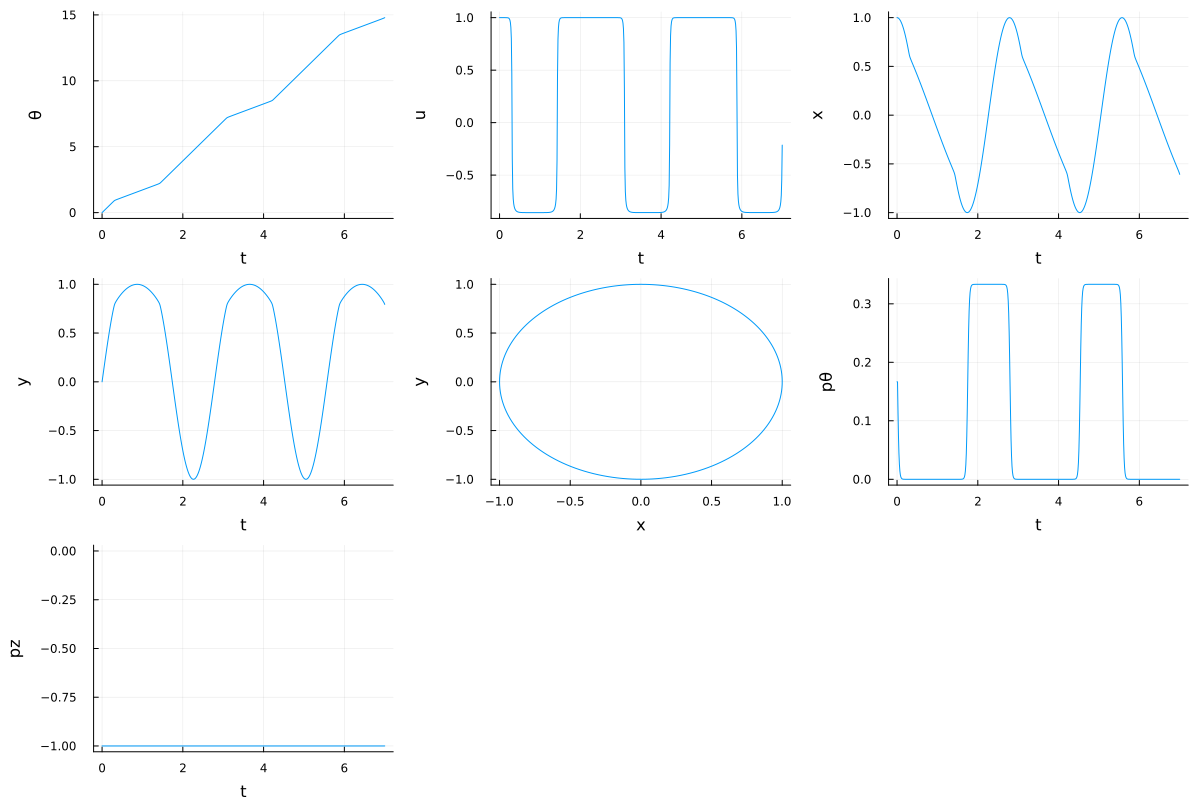

In [34]:
# Plots
t  = sol.t
θ  = sol.θ
z  = sol.z
u  = sol.u
pθ = sol.pθ
pz = sol.pz

x  = cos.(θ)  
y  = sin.(θ) 

x_plot     = plot(t, x,  xlabel = "t", ylabel = "x",  legend = false)
y_plot     = plot(t, y,  xlabel = "t", ylabel = "y",  legend = false)
xy_plot    = plot(x, y,  xlabel = "x", ylabel = "y",  legend = false)

pθ_plot     = plot(t, pθ,  xlabel = "t", ylabel = "pθ",  legend = false)
pz_plot     = plot(t, pz,  xlabel = "t", ylabel = "pz",  legend = false)


θ_plot    = plot(t, θ,  xlabel = "t", ylabel = "θ",  legend = false)

u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)


plot(θ_plot, u_plot ,x_plot,y_plot,xy_plot,pθ_plot, pz_plot, layout = (3,3), size=(1200,800), left_margin=5mm)

In [26]:
u1 = copy(u)

switching = findall(abs.(diff(u1)) .> 0.45) .+ 1  ;
switching_times = t[switching]

Float64[]

In [8]:
#using Animations
#using Reel

In [9]:
 # create an animation
#animx = @animate for i = 1:length(t)
 #   plot(x[1:i], y[1:i], xlim=(-2.,2.), ylim=(-2.,2.), xlabel="x", ylabel="y", label="trajectory", linecolor=:blue)
  #  scatter!([x[i]], [y[i]], label=false, markercolor=:blue)
#end


In [10]:
#gif(animx, "animationx.gif", fps = 150)

In [11]:
using NLsolve
using Reel
include("flow.jl");
using LinearAlgebra;

function g(x)
    if 0. < x < π || 2*π < x < 3*π ||  4*π < x < 5*π  
        return 1.
    else
        return 0.
    end
end;


In [12]:
# Dynamics x = [θ,z]
function F0(x)
    return [2. , g(x[1]) ]
end

function F1(x)
    return [1. , 0.]
end

# Hamiltonians and associated flows
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)

H(x, p, u) = H0(x, p) + u*H1(x,p) # pseudo-Hamiltonian

up(x, p) =  1
um(x, p) = -1

Hp(x, p) = H(x, p, up(x, p))
Hm(x, p) = H(x, p, um(x, p))

#flows
fp = Flow(Hp)
fm = Flow(Hm);

In [13]:
t0  = 0.0
T   = 6.5
x0  = [0.0; 0.0]

# Shooting function
function shoot(p0, t1, t2, t3, t4, t5) # B+ B- B+ B- B+ B-
    
    x1, p1 = fp(t0, x0, p0, t1)
    x2, p2 = fm(t1, x1, p1, t2)
    x3, p3 = fp(t2, x2, p2, t3)
    x4, p4 = fm(t3, x3, p3, t4)
    x5, p5 = fp(t4, x4, p4, t5)
    x6, p6 = fm(t5, x5, p5, T)
    
    s = zeros(eltype(p0), 7)
    
    s[1:2] = p6 - [0., 1.] # transversality condition
    
    s[3] = H1(x1, p1) # switching
    s[4] = H1(x2, p2) # switching
    s[5] = H1(x3, p3) # switching
    s[6] = H1(x4, p4) # switching
    s[7] = H1(x5, p5) # switching


    return s

end;

In [14]:
S(ξ) = shoot(ξ[1:2],ξ[3],ξ[4],ξ[5],ξ[6],ξ[7])

S (generic function with 1 method)

In [15]:
ξ_guess = [pθ[1], pz[1], switching_times[1], switching_times[2], switching_times[3], switching_times[4], switching_times[5]] # initial guess

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1]

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [16]:
S(ξ_guess)

LoadError: UndefVarError: ξ_guess not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [17]:
#solve


indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0 = indirect_sol.zero[1:2]
    tt1 = indirect_sol.zero[3]
    tt2 = indirect_sol.zero[4]
    tt3 = indirect_sol.zero[5]
    tt4 = indirect_sol.zero[6]
    tt5 = indirect_sol.zero[7]
    
else
    error("Not converged")
end;

LoadError: UndefVarError: ξ_guess not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [18]:
ode_sol = fp((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1    = ode_sol.t ;
xx1     = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1     = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1     = 1*ones(length(ttt1)) ;

LoadError: UndefVarError: tt1 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [19]:
ode_sol = fm((tt1, tt2), xx1[end], pp1[end], saveat=0.1) ;
ttt2    = ode_sol.t ;
xx2     = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ] ;
pp2     = [ ode_sol[3:4, j] for j in 1:size(ttt2, 1) ] ;
uu2     = (-1)*ones(length(ttt2)) ;

LoadError: UndefVarError: xx1 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [20]:
ode_sol = fp((tt2, tt3), xx2[end], pp2[end], saveat=0.1) ;
ttt3    = ode_sol.t ;
xx3     = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ] ;
pp3     = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] ;
uu3     = (1)*ones(length(ttt3)) ;

LoadError: UndefVarError: xx2 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [21]:
ode_sol = fm((tt3, tt4), xx3[end], pp3[end], saveat=0.1) ;
ttt4    = ode_sol.t ;
xx4     = [ ode_sol[1:2, j] for j in 1:size(ttt4, 1) ] ;
pp4     = [ ode_sol[3:4, j] for j in 1:size(ttt4, 1) ] ;
uu4     = (-1)*ones(length(ttt4)) ;

LoadError: UndefVarError: xx3 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [22]:
ode_sol = fp((tt4, tt5), xx4[end], pp4[end], saveat=0.1) ;
ttt5    = ode_sol.t ;
xx5     = [ ode_sol[1:2, j] for j in 1:size(ttt5, 1) ] ;
pp5     = [ ode_sol[3:4, j] for j in 1:size(ttt5, 1) ] ;
uu5     = (1)*ones(length(ttt5)) ;

LoadError: UndefVarError: xx4 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [23]:
ode_sol = fm((tt5, T), xx5[end], pp5[end], saveat=0.1) ;
ttt6    = ode_sol.t ;
xx6     = [ ode_sol[1:2, j] for j in 1:size(ttt6, 1) ] ;
pp6     = [ ode_sol[3:4, j] for j in 1:size(ttt6, 1) ] ;
uu6     = (-1)*ones(length(ttt6)) ;

LoadError: UndefVarError: xx5 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [24]:
t = [ ttt1 ; ttt2 ; ttt3 ; ttt4 ; ttt5 ; ttt6]
x = [ xx1 ; xx2 ; xx3 ; xx4 ; xx5 ; xx6 ]
p = [ pp1 ; pp2 ; pp3 ; pp4 ; pp5 ; pp6 ]
u = [ uu1 ; uu2 ; uu3 ; uu4 ; uu5 ; uu6 ]

m = length(t)

θ1  = [ x[i][1] for i=1:m ]
z1  = [ x[i][2] for i=1:m ]
pθ1 = [ p[i][1] for i=1:m ]
pz1 = [ p[i][2] for i=1:m ];

x11  = cos.(θ1)  
y11  = sin.(θ1) ;



LoadError: UndefVarError: ttt1 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [25]:
x11_plot     = plot(t, x11,  xlabel = "t", ylabel = "x",  legend = false)
y11_plot     = plot(t, y11,  xlabel = "t", ylabel = "y",  legend = false)
xxyy_plot    = plot(x11, y11,  xlabel = "x", ylabel = "y",  legend = false)

pθ1_plot     = plot(t, pθ1,  xlabel = "t", ylabel = "pθ",  legend = false)
pz1_plot     = plot(t, pz1,  xlabel = "t", ylabel = "pz",  legend = false)


θ1_plot    = plot(t, θ1,  xlabel = "t", ylabel = "θ",  legend = false)

u1_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)


plot(θ1_plot, u1_plot ,x11_plot,y11_plot,xxyy_plot,pθ1_plot, pz1_plot, layout = (3,3), size=(1200,800), left_margin=5mm)

LoadError: UndefVarError: x11 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.
